# **Aims/Learning Objectives:**

Learn how different attention mechanisms can be implemented.

Learn and create the basic building blocks from scratch for the most common transformer architectures.

Learn how to train a sequence-sequence model.

Learn how to use the Hugging Face library for quicker development cycles and build a chatbot intent model.

**Prerequisites:**

Basic understanding of Jax and Haiku

Basic understanding of linear algebra

RNN based sequence-sequence models

Word2Vec

In [43]:
# !pip install transformers

In [5]:
# !pip install datasets

In [6]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

# !pip install git+https://github.com/deepmind/dm-haiku flax optax
# !pip install transformers==4.12.1 datasets
# !pip install seaborn umap-learn
# !pip install livelossplot

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import haiku as hk
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets

import optax

from PIL import Image
from livelossplot import PlotLosses


import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
import random

# download images used in notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)


import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

a GPU is connected.


[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

# Sequence to sequence attenion mechanisms

In [7]:
# @title Helper Functions. (Run Cell)


def plot_position_encodings(P, max_tokens, d_model):
    """Function that takes in a position encoding matrix and plots it."""

    plt.figure(figsize=(20, np.min([8, max_tokens])))
    im = plt.imshow(P, aspect="auto", cmap="Blues_r")
    plt.colorbar(im, cmap="blue")

    if d_model <= 64:
        plt.xticks(range(d_model))
    if max_tokens <= 32:
        plt.yticks(range(max_tokens))
    plt.xlabel("Embedding index")
    plt.ylabel("Position index")
    plt.show()


def plot_image_patches(patches):
    """Function that takes in a list of patches and plots them."""
    axes = []
    fig = plt.figure(figsize=(25, 25))
    for a in range(patches.shape[1]):
        axes.append(fig.add_subplot(1, patches.shape[1], a + 1))
        plt.imshow(patches[0][a])
    fig.tight_layout()
    plt.show()


def plot_projected_embeddings(embeddings, labels):
    """Function that takes in a list of embeddings projects them onto a 2D space and plots them using UMAP."""
    import umap
    import seaborn as sns

    projected_embeddings = umap.UMAP().fit_transform(embeddings)

    plt.figure(figsize=(15, 8))
    plt.title("Projected text embeddings")
    sns.scatterplot(
        x=projected_embeddings[:, 0], y=projected_embeddings[:, 1], hue=labels
    )
    plt.show()


def get_word2vec_embedding(words):
    """
    Function that takes in a list of words and returns a list of their embeddings,
    based on a pretrained word2vec encoder.
    """
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )

    output = []
    words_pass = []
    for word in words:
        try:
            output.append(jnp.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass

    embeddings = jnp.array(output)
    del model  # free up space again
    return embeddings, words_pass


def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """Function that takes in a weight matrix and plots it with custom axis ticks"""
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1]) + 0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0]) + 0.5, y_ticks)
    plt.title("Attention matrix")
    plt.xlabel("Attention score")
    plt.show()


def remove_punctuation(text):
    """Function that takes in a string and removes all punctuation."""
    import re

    text = re.sub(r"[^\w\s]", "", text)
    return text

In [8]:
# @title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [gpu(id=0)]


In [11]:
def dot_product_attention(hidden_states, previous_state):
  """
  Calculate the dot product between the hidden states and previous states.

  Args:
    hidden_states: A tensor with shape [T_hidden, dm]
    previous_state: A tensor with shape [T_previous, dm]
  """
  # [T,d]*[d,N] -> [T,N]
  scores = jnp.matmul(previous_state, hidden_states.T)
  w_n = jax.nn.softmax(scores)
  # [T,N]*[N,d] -> [T,d]
  c_t = jnp.matmul(w_n, hidden_states)

  return w_n, c_t

In [12]:
# @title Run me to test your code

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [2, 2])
w_n, c_t = dot_product_attention(x, x)

w_n_correct = jnp.array([[0.9567678, 0.04323225], [0.00121029, 0.99878967]])
c_t_correct = jnp.array([[0.11144122, 0.95290256], [-1.5571996, -1.5321486]])

assert jnp.allclose(w_n_correct, w_n), "w_n is not calculated correctly"
assert jnp.allclose(c_t_correct, c_t), "c_t is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


<ipython-input-7-af46861a2e17>:60: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


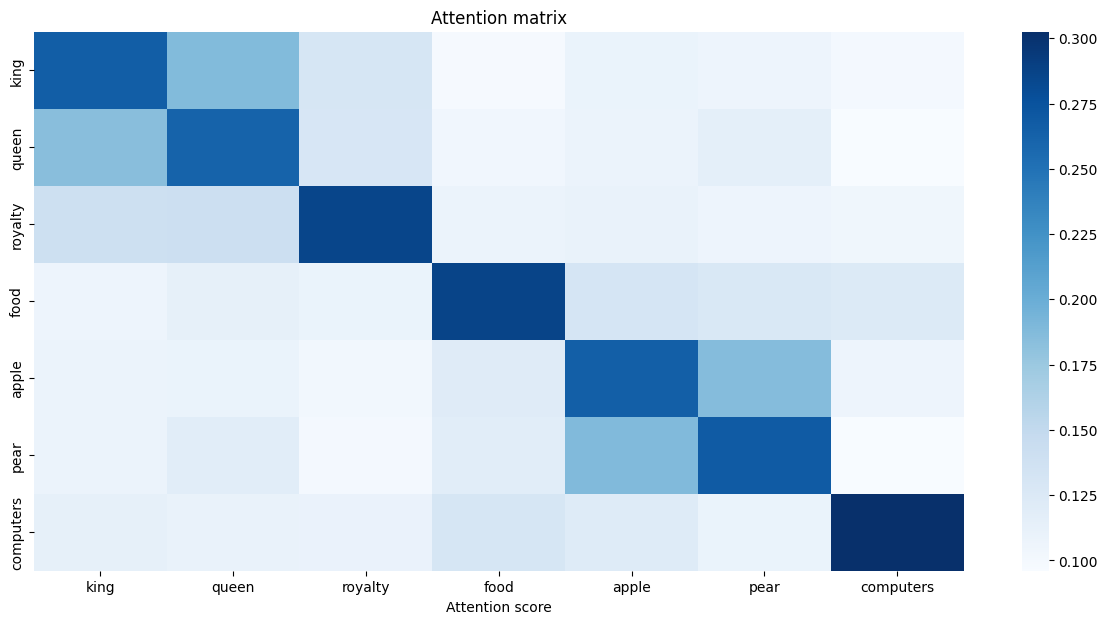

In [13]:
# when changing these words, note that if the word is not in the original
# training corpus it will not be shown in the weight matrix plot.
words = ["king", "queen", "royalty", "food", "apple", "pear", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

# **Self-attention to Multihead Attention**

In [14]:
def embed_sentence(sentence):
    # Embed a sentence using word2vec; for example use cases only.
    sentence = remove_punctuation(sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return jnp.expand_dims(word_vector_sequence, axis=0), words

**Self-attention**

In [15]:
class SequenceToQKV(hk.Module):

  '''
  Project a sequence of embeddings to query, key and value matrices.

  Args:
    output_size: The embedding dimension for the Q,K,V matrices.
  '''

  def __init__(self, output_size):

    super().__init__()

    self.output_size = output_size

  def __call__(self, X):
    '''
    Project X to Q,K,V matrices.

    Args:
      X: Sequence of embeddings with shape [B,T,d], where T is sequence length.
    Returns:
      Q,K,V: The three projected matrices with shape [B,T,output_size]
    '''

    initializer = hk.initializers.VarianceScaling(0.5)

    # this can also be one layer, how do you think you would do it?
    q_layer = hk.Linear(self.output_size, w_init=initializer)
    k_layer = hk.Linear(self.output_size, w_init=initializer)
    v_layer = hk.Linear(self.output_size, w_init=initializer)

    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

In [16]:
# @title Run me to test your code
def x_to_qkv(sequences):
    qkv_transforms = SequenceToQKV(2)
    return qkv_transforms(sequences)


x_to_qkv = hk.transform(x_to_qkv)

# initialise model
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [1, 1, 1])
params = x_to_qkv.init(key, x)
Q, K, V = x_to_qkv.apply(params, key, x)

Q_correct = jnp.array([[[-0.22509536, 0.03467613]]])
K_correct = jnp.array([[[-0.01319892, 0.17290935]]])
V_correct = jnp.array([[[-0.07143524, -0.01425235]]])

assert jnp.allclose(Q_correct, Q), "Q is not calculated correctly"
assert jnp.allclose(K_correct, K), "K is not calculated correctly"
assert jnp.allclose(V_correct, V), "V is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


**Scaled dot product attention**

In [18]:
def scaled_dot_product_attention(query, key, value):
  '''
  Calculate the scaled dot product attention using
  query, key and value tokens.

  Args:
    query: Query matrix, with shape [B,T,d]
    key: Key matrix, with shape [B,T_key,d]
    value: Value matrix, with shape [B,T_key,d]

  Returns:
    value: Weighted sum of values with shape [B,T,d]
    attention_weights: The attention weights between query and key, shape [B,T,T_key]
  '''

  d_k = key.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits / jnp.sqrt(d_k)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1)
  value = jnp.matmul(attention_weights, value)
  return value, attention_weights

In [19]:
# @title Run me to test your code
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [1, 2, 3])
value, weights = scaled_dot_product_attention(x, x, x)

value_correct = jnp.array(
    [[[0.5013704, 0.965935, 1.0586468], [-0.57923466, -0.56055915, 0.2919087]]]
)
weights_correct = jnp.array([[[0.9221789, 0.0778211], [0.16385838, 0.8361416]]])

assert jnp.allclose(value_correct, value), "value is not calculated correctly"
assert jnp.allclose(
    weights_correct, weights
), "attention_weights is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


<ipython-input-7-af46861a2e17>:60: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(jnp.array(model.word_vec(word)))


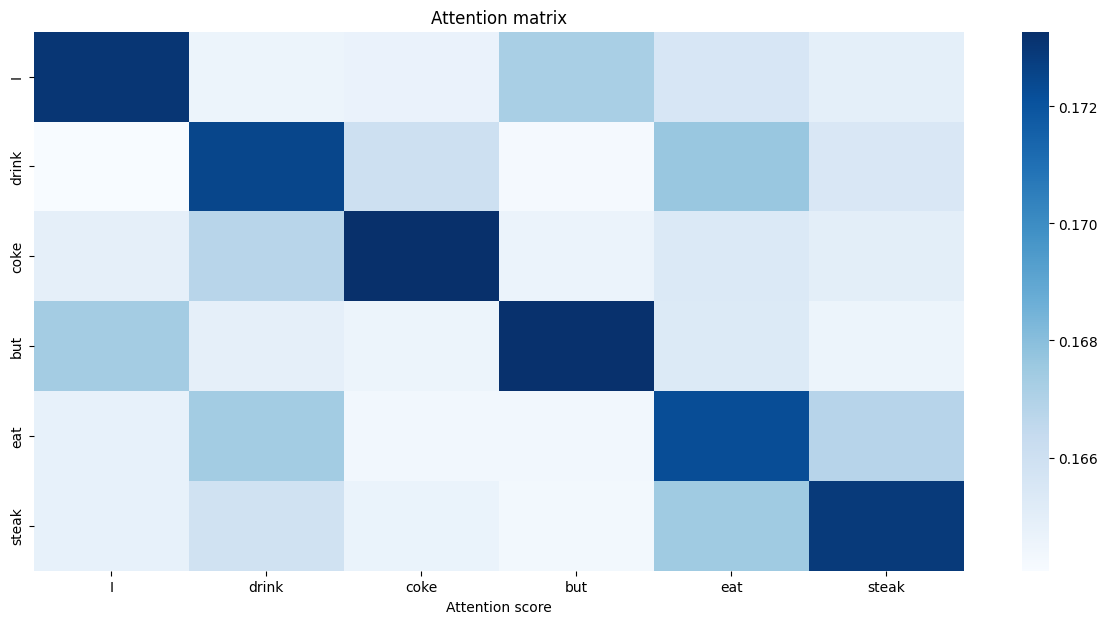

In [20]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
Q = K = V = word_embeddings

# calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q, K, V)
words = remove_punctuation(sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words)

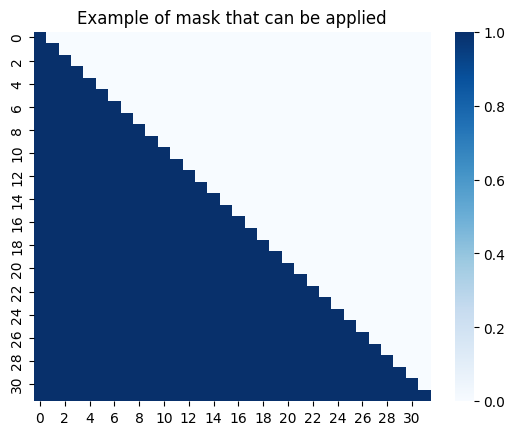

In [21]:
# example of building a mask for tokens of size 32
mask = jnp.tril(jnp.ones((32, 32)))
sns.heatmap(mask, cmap="Blues")
plt.title("Example of mask that can be applied");

In [25]:
def scaled_dot_product_attention(query, key, value, mask=None):
  '''
  Calculate the scaled dot product attention using
  query, key and value tokens with mask being applied.

  Args:
    query: Query matrix, with shape [B,T,d]
    key: Key matrix, with shape [B,T_key,d]
    value: Value matrix, with shape [B,T_key,d]
    mask: Mask to be applied, with shape [T_mask, T_mask], where T_mask>=max(T_key,T)

  Returns:
    value: Weighted sum of values with shape [B,T,d]
    attention_weights: The attention weights between query and key, shape [B,T,T_key]
  '''
  d_k = key.shape[-1]
  T_k = key.shape[1]
  T_q = query.shape[1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits/jnp.sqrt(d_k)

  if mask is not None:
    scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)


  attention_weights = jax.nn.softmax(scaled_logits, axis=-1)
  attention = jnp.matmul(attention_weights, value)
  return attention, attention_weights

In [26]:
# @title Run me to test your code
mask = jnp.tril(jnp.ones((2, 2)))

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [1, 2, 3])

value, weights = scaled_dot_product_attention(x, x, x, mask)

value_correct = jnp.array(
    [[[0.6122652, 1.1225883, 1.1373317], [-0.57923466, -0.56055915, 0.2919087]]]
)
weights_correct = jnp.array([[[1.0, 0.0], [0.16385838, 0.8361416]]])

assert jnp.allclose(value_correct, value), "value is not calculated correctly"
assert jnp.allclose(
    weights_correct, weights
), "attention_weights is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


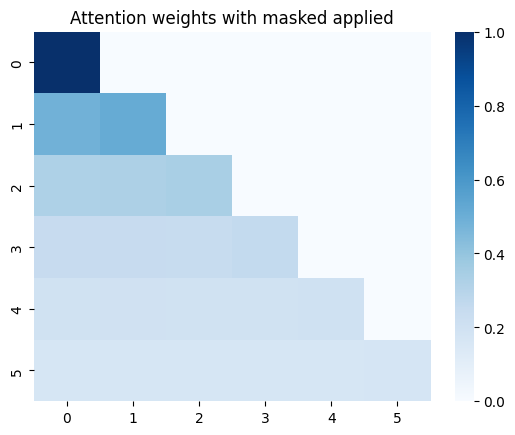

In [27]:
mask = jnp.tril(np.ones((word_embeddings.shape[1], word_embeddings.shape[1])))

attention, attention_weights = scaled_dot_product_attention(
    word_embeddings, word_embeddings, word_embeddings, mask
)

plt.title("Attention weights with masked applied")
sns.heatmap(attention_weights[0], cmap="Blues");

# **Multihead Attention - Advanced**

In [28]:
class MultiHeadAttention(hk.Module):

  '''
  Apply multi-head attention to a sequence of embeddings, or to Q, K and V
  matrices if they are supplied.

  Args:
    num_heads: Number of heads
    d_m: Embedding/Token embeddings size
  '''

  def __init__(
      self,
      num_heads,
      d_m,
      name = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads
    self.sequence_to_qkv = SequenceToQKV(d_m)  # Implemented in the previous exercises

  def __call__(self, X=None, Q=None, K=None, V=None, mask = None, return_weights=False):
    '''
    Args:
      X: Sequence of embeddings, with shape [B,T,dm]. If not provided, must provide Q,K,V
      Q: Query matrix, with shape [B,T,dm]. Must be provided if X is not
      K: Query matrix, with shape [B,T_key,dm]. Must be provided if X is not
      V: Query matrix, with shape [B,T_key,dm]. Must be provided if X is not
      mask [optional, default=None]: Mask to be applied, with shape [T_mask, T_mask], where T_mask>=max(T_key,T).
      return_weights [optional, default=False]: Whether to return attention weights calculated

    Returns:
      X_new: Transformed sequence of embeddings, with shape [B,T,dm]
      attention_weights: Returned when return_weights=True, with shape [B,num_heads,T,T_key]

    '''


    if None in [Q, K, V]:
      assert not X is None, 'X has to be provided if either Q,K,V not provided'

      # project all data to Q, K, V
      Q,K,V = self.sequence_to_qkv(X)

    # get the batch size, sequence length and embedding size
    B, T, d_m = K.shape

    # calculate heads embedding size (d_m/N)
    head_size = d_m // self.num_heads

    # B,T,d_m -> B, T, N, dm//N -> B, N, T, dm//N
    q_heads = Q.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)
    k_heads = K.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)
    v_heads = V.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)

    attention, attention_weights = scaled_dot_product_attention(q_heads,k_heads,v_heads,mask)

    # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, d_m) - re-assemble all head outputs
    attention = attention.swapaxes(1, 2).reshape(B, -1, d_m)

    # apply Wo
    initializer = hk.initializers.VarianceScaling(0.5)
    Wo = hk.Linear(d_m, w_init=initializer)
    X_new = Wo(attention)

    if return_weights:
      return X_new, attention_weights
    else:
      return X_new

In [29]:
# @title Run me to test your code
def mha_test(sequences):
    mha = MultiHeadAttention(2, 8)
    return mha(sequences)


mha_test = hk.transform(mha_test)

# initialise model
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [1, 2, 8])
params = mha_test.init(key, x)
x_new = mha_test.apply(params, key, x)

x_correct = jnp.array(
    [
        [
            [
                0.8122552,
                -0.3184167,
                0.54364735,
                1.0808588,
                0.28692305,
                0.44296914,
                -0.0463711,
                0.12337256,
            ],
            [
                0.8388398,
                -0.39584604,
                0.30241585,
                0.9982894,
                0.3577416,
                0.35978147,
                -0.07165723,
                -0.18380073,
            ],
        ]
    ]
)


assert jnp.allclose(x_correct, x_new), "Not returning the correct value"
print(
    "It seems correct. Look at the answer below to compare methods then move to the transformers section."
)

It seems correct. Look at the answer below to compare methods then move to the transformers section.


In [31]:
# # @title Generate Quiz Form. (Run Cell)
# from IPython.display import HTML

# HTML(
#     """
# <iframe
# 	src="https://forms.gle/h6jjUePGPxGdWkjW8",
#   width="80%"
# 	height="1200px" >
# 	Loading...
# </iframe>
# """
# )

# **Transformers**

In [32]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_input = bert_tokenizer("The practical is so much fun")
print(f"Token IDs: {encoded_input['input_ids']}")

Token IDs: [101, 1109, 6691, 1110, 1177, 1277, 4106, 102]


In [33]:
print(f"Tokens: {bert_tokenizer.decode(encoded_input['input_ids'])}")

Tokens: [CLS] The practical is so much fun [SEP]


In [36]:
def image_to_patch(image, patch_size):
    """
    Inputs:
        x - array of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)

    Outputs:
        patches - array of shape [B, H'*W', p_H, p_W, C]
    """
    B, H, W, C = image.shape
    image = image.reshape(
        B, H // patch_size, patch_size, W // patch_size, patch_size, C
    )

    image = image.transpose(0, 1, 3, 2, 4, 5)  # [B, H', W', p_H, p_W, C]
    image_patches = image.reshape(B, -1, *image.shape[3:])  # [B, H'*W', p_H, p_W, C]
    return image_patches

Original image:


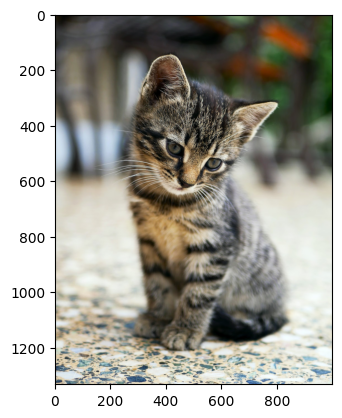

Image broken into patches


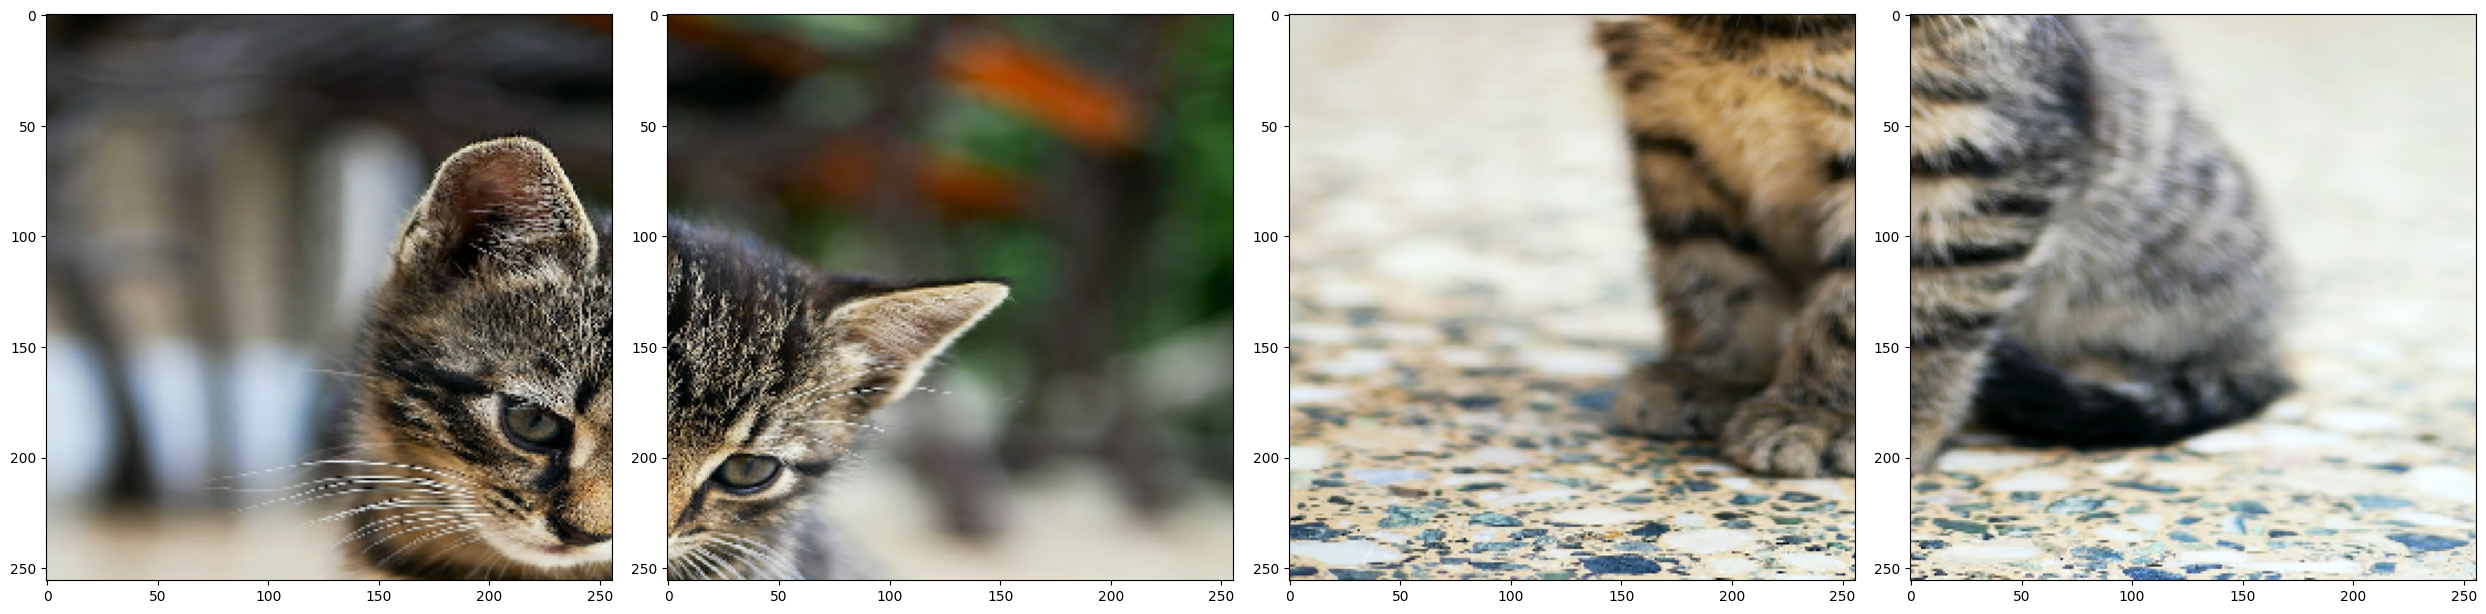

In [37]:
# do not change these lines, only run them to test your function
print("Original image:")
image = np.array(Image.open("cat.png"))
plt.imshow(image)
plt.show()

print("Image broken into patches")
img = jnp.array(image)
img = jax.image.resize(img, (512, 512, 3), "nearest")
img = jnp.expand_dims(img, 0)
patches = image_to_patch(img, 256)
plot_image_patches(patches)

# **Positional encodings**

Sine and cosine functions

In [38]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

    assert token_embedding % 2 == 0, "token_embedding should be divisible by two"

    P = jnp.zeros((token_sequence_length, token_embedding))
    positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

    i = jnp.arange(0, token_embedding, 2)
    frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
    frequencies = positions * frequency_steps

    P = P.at[:, 0::2].set(jnp.sin(frequencies))
    P = P.at[:, 1::2].set(jnp.cos(frequencies))

    return P

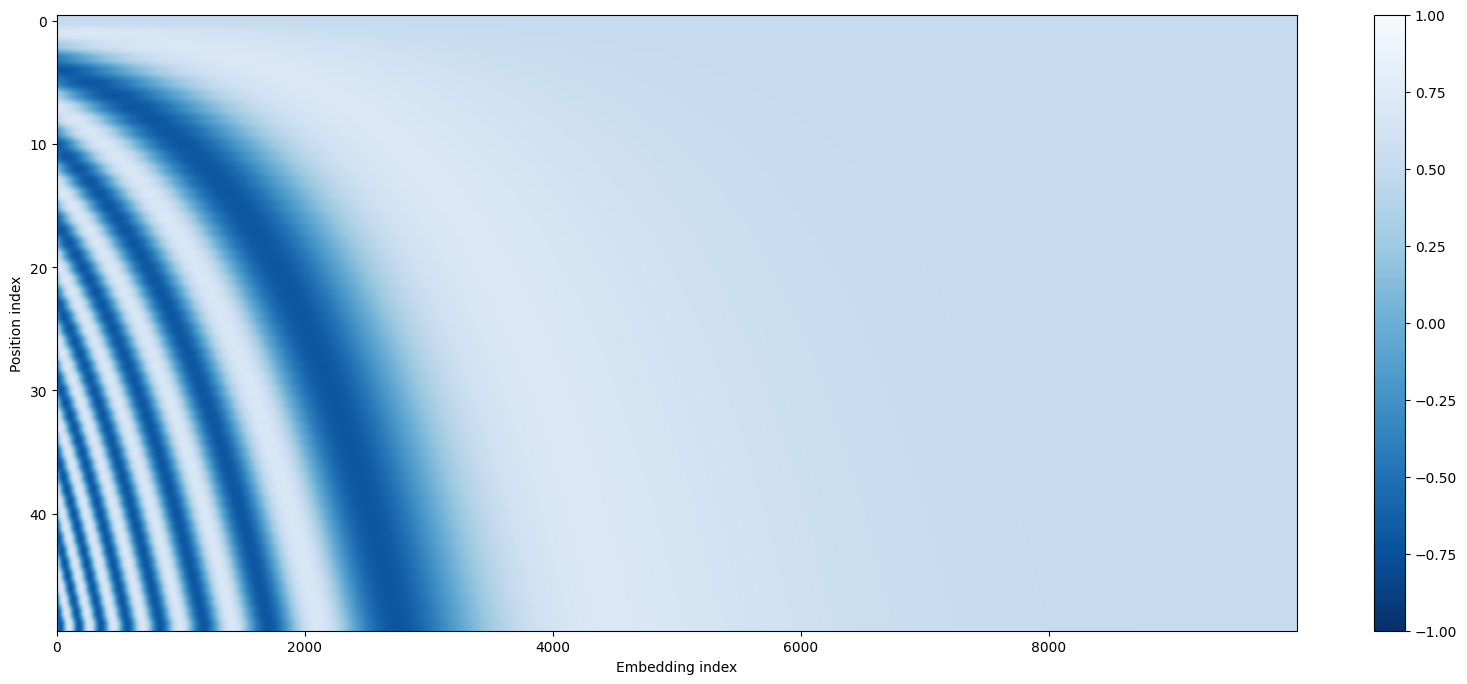

In [39]:
token_sequence_length = 50  # Number of tokens the model will need to process
token_embedding = 10000  # token embedding (and positional encoding) dimensions, ensure it is divisible by two
P = return_frequency_pe_matrix(token_sequence_length, token_embedding)
plot_position_encodings(P, token_sequence_length, token_embedding)

In [40]:
#@title Answer (but first try yourself)
%%latex
\frac{𝐷}{x^{𝑖/𝑑_𝑚}} \\
= D\left( x^{-i/d_m}\right)\\
=\text{exp}\left(\log{x^{-i/d_m}}\right)D\\
=\text{exp}\left(\frac{-i}{d_m}\log{x}\right)D\\
=\text{exp}\left(\frac{-i\log{x}}{d_m}\right)D

<IPython.core.display.Latex object>

In [41]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.


class PositionEmbeddingsLookup(hk.Module):
    """
    A position embedding of shape [max_sequence_len, d_model]
    """

    def __init__(self, max_sequence_len, d_model):
        super().__init__()

        self.max_sequence_len = max_sequence_len
        self.d_model = d_model

    def __call__(self, sequence):

        assert (
            sequence.shape[0] <= self.max_sequence_len
        ), f"Sequence to long, max lenght={self.max_sequence_len}"

        lookup_table = hk.get_parameter(
            name="position_embedding",
            shape=(self.max_sequence_len, self.d_model),
            init=jnp.zeros,
        )

        return lookup_table[: sequence.shape[0], :]

In [42]:
# @title Run me to test your code
def pos_test(sequences):
    pos_emb = PositionEmbeddingsLookup(2, 8)
    return pos_emb(sequences)


pos_test = hk.transform(pos_test)

# initialise model
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, [1, 2, 8])
params = pos_test.init(key, x)
pos_encoding = pos_test.apply(params, key, x)

pos_correct = jnp.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

assert jnp.allclose(pos_correct, pos_encoding), "Not returning the correct value"
print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


# **Feed Forward block**

In [44]:
class FeedForwardBlock(hk.Module):
  """
  A 2-layer MLP which widens then narrows the input.

  Args:
    widening_factor [optional, default=4]: The size of the hidden layer will be d_model * widening_factor.
  """

  def __init__(self,
               widening_factor: int = 4,
               name=None):
    super().__init__(name=name)
    self._init_scale = 0.25
    self._widening_factor = widening_factor

  def __call__(self, x):
    '''
    Args:
      x: [B, T, d_m]

    Return:
      x: [B, T, d_m]
    '''
    d_m = x.shape[-1]
    layer1_size = self._widening_factor * d_m

    initializer = hk.initializers.VarianceScaling(self._init_scale)
    layer1 = hk.Linear(layer1_size, w_init=initializer)
    layer2 = hk.Linear(d_m, w_init=initializer)


    x = jax.nn.gelu(layer1(x))
    x = layer2(x)
    return x

# **Add and Norm**

In [45]:
class AddNorm(hk.Module):
  """A block that impliments the add and norm block"""

  def __init__(self,
               name=None):
    super().__init__(name=name)

  def __call__(self, x, processed_x):
    '''
    Args:
      x: Sequence of tokens before feeding into MHA or FF blocks, with shape [B, T, d_m]
      x: Sequence of after being processed by MHA or FF blocks, with shape [B, T, d_m]

    Return:
      add_norm_x: Transformed tokens with shape [B, T, d_m]
    '''

    added = x + processed_x
    normalised = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
    return normalised(added)

# **Building the Encoder**

In [46]:
class EncoderBlock(hk.Module):
  """
  An encoder block for the Transformer stack.

  Args:
    num_heads: The number of heads to be used in the MHA block.
    d_m: Token embedding size
    widdening_factor: The size of the hidden layer will be d_m * widening_factor.
  """

  def __init__(self, num_heads, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self._num_heads = num_heads
    self.d_m = d_m
    self.mha = MultiHeadAttention(num_heads, d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=widening_factor)

  def __call__(self, X, mask=None, return_att_weight=True):
    '''
    Args:
      X: Batch of tokens, with shape [B, T, d_m]
      mask [optional, default=None]: Mask to be applied, with shape [T, T].
      return_att_weight [optional, default=True]: Whether to return the attention weights.
    '''

    sequence_len = X.shape[-2]
    positions = return_frequency_pe_matrix(sequence_len, self.d_m)
    X = X + positions
    attention, attention_weights = self.mha(X, mask, return_weights=True)
    X = self.add_norm1(X, attention)
    projection =  self.MLP(X)
    X = self.add_norm2(X, projection)
    return (X, attention_weights) if return_att_weight else X

In [47]:
class TransformerEncoder(hk.Module):
    """
    Transformer encoder consisting of several layers of encoder blocks.

    Args:
      num_heads: The number of heads to be used in the MHA block.
      num_layers: The number of encoder blocks to be used.
      d_m: Token embedding size
      widdening_factor: The size of the hidden layer will be d_m * widening_factor.
    """

    def __init__(
        self, num_heads: int, num_layers: int, d_m: int, widening_factor=4, name=None
    ):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.widening_factor = widening_factor
        self.blocks = [
            EncoderBlock(self.num_heads, d_m, self.widening_factor)
            for _ in range(num_layers)
        ]

    def __call__(self, X, mask, return_att_weights=False):
        """
        Args:
          X: Batch of tokens, with shape [B, T, d_m]
          mask [optional, default=None]: Mask to be applied, with shape [T, T].
          return_att_weight [optional, default=True]: Whether to return the attention weights.
        """

        if return_att_weights:
            att_weights = []

        for block in self.blocks:
            out = block(X, mask, return_att_weights)

            if return_att_weights:
                X = out[0]
                att_weights.append(out[1])
            else:
                X = out

        return (
            X if not return_att_weights else (X, jnp.array(att_weights).swapaxes(0, 1))
        )

In [48]:
# @title Run me to test your encoder
B, T, d_m, N = 2, 2, 2, 2

# run this to test if your code is running
def encode(
    sequences,
    num_heads=2,
    num_layers=2,
    widening_factor=4,
    d_m=d_m,
    return_weights=False,
):
    encoder = TransformerEncoder(num_heads, num_layers, d_m, widening_factor)
    return encoder(sequences, None, return_weights)


encode = hk.transform(encode)

# initialise module
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T, d_m])
params = encode.init(key, X, N, d_m)
encoded_x = encode.apply(params, key, X)

correct_encoded_x = jnp.array(
    [
        [[-0.99999505, 0.99999505], [0.9999963, -0.9999963]],
        [[-0.99999505, 0.99999505], [0.9999963, -0.9999963]],
    ]
)

assert jnp.allclose(
    correct_encoded_x, encoded_x
), "Not returning the correct value, investigate previous blocks"
print("It seems correct. Move on to building the decoder")

It seems correct. Move on to building the decoder


# **Building the Decoder**

In [49]:
class DecoderBlock(hk.Module):
    """
    Transformer decoder block.

    Args:
      num_heads: The number of heads to be used in the MHA block.
      d_m: Token embedding size
      widdening_factor: The size of the hidden layer will be d_m * widening_factor.
    """

    def __init__(self, num_heads, d_m, widening_factor=4, name=None):
        super().__init__(name=name)

        self._num_heads = num_heads
        self.d_m = d_m
        self.mha = MultiHeadAttention(num_heads, d_m)
        self.mha_combine = MultiHeadAttention(num_heads, d_m)
        self.add_norm1 = AddNorm()
        self.add_norm2 = AddNorm()
        self.add_norm3 = AddNorm()
        self.MLP = FeedForwardBlock(widening_factor=widening_factor)

    def __call__(self, X, encoder_output, mask=None, return_att_weight=True):
        """
        Args:
          X: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
          encoder_output: Batch of tokens with was processed by the encoder, with shape [B, T_encoder, d_m]
          mask [optional, default=None]: Mask to be applied, with shape [T_decoder, T_decoder].
          return_att_weight [optional, default=True]: Whether to return the attention weights.
        """

        sequence_len = X.shape[-2]
        positions = return_frequency_pe_matrix(sequence_len, self.d_m)
        X = X + positions

        attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

        X = self.add_norm1(X, attention)

        attention, attention_weights_2 = self.mha_combine(
            Q=X, K=encoder_output, V=encoder_output, mask=mask, return_weights=True
        )

        X = self.add_norm2(X, attention)
        projection = self.MLP(X)
        X = self.add_norm3(X, projection)

        return (X, attention_weights_2) if return_att_weight else X

In [50]:
class TransformerDecoder(hk.Module):
    """
    Transformer encoder consisting of several layers of decoder blocks.

    Args:
      num_heads: The number of heads to be used in the MHA block.
      num_layers: The number of decoder blocks to be used.
      d_m: Token embedding size
      widdening_factor: The size of the hidden layer will be d_m * widening_factor.
    """

    def __init__(
        self, num_heads: int, num_layers: int, d_m: int, widening_factor=4, name=None
    ):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.widening_factor = widening_factor
        self.blocks = [
            DecoderBlock(self.num_heads, d_m, self.widening_factor)
            for _ in range(num_layers)
        ]

    def __call__(self, X, encoder_output, mask, return_att_weights=False):
        """
        Args:
          X: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
          encoder_output: Batch of tokens with was processed by the encoder, with shape [B, T_encoder, d_m]
          mask [optional, default=None]: Mask to be applied, with shape [T_decoder, T_decoder].
          return_att_weight [optional, default=True]: Whether to return the attention weights.
        """

        if return_att_weights:
            att_weights = []
        for block in self.blocks:
            out = block(X, encoder_output, mask, return_att_weights)
            if return_att_weights:
                X = out[0]
                att_weights.append(out[1])
            else:
                X = out

        return (
            X if not return_att_weights else (X, jnp.array(att_weights).swapaxes(0, 1))
        )

In [51]:
class Transformer(hk.Module):
  """

  A full transformer encoder-decoder architecture

  Args:
    num_heads: The number of heads to be used in the MHA blocks.
    num_layers: The number of decoder and encoder blocks to be used.
    d_m: Token embedding size
    widdening_factor: The size of the hidden layer will be d_m * widening_factor.
  """

  def __init__(self, num_heads, num_layers, d_m, widening_factor=4, name=None):
    super().__init__(name=name)

    self.num_layers = num_layers
    self.num_heads = num_heads

    self.encoder = TransformerEncoder(num_heads, num_layers, d_m, widening_factor)
    self.decoder = TransformerDecoder(num_heads, num_layers, d_m, widening_factor)

  def __call__(self, X_encoder, X_decoder, encoder_mask, decoder_mask, return_weights):
    '''
    Args:
      X_encoder: Batch of tokens being fed into the enecoder, with shape [B, T_encoder, d_m]
      X_decoder: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
      encoder_mask: Mask to be applied, with shape [T_encoder, T_encoder]. If None, masking will not be applied.
      decoder_mask: Mask to be applied, with shape [T_decoder, T_decoder]. If None, masking will not be applied.
      return_att_weight: Whether to return the attention weights.
    '''

    encoder_out = self.encoder(X_encoder, encoder_mask, return_weights)
    attention_input = encoder_out[0] if return_weights else encoder_out
    decoder_out = self.decoder(
            X_decoder, attention_input, decoder_mask, return_weights
        )
    logits = decoder_out[0] if return_weights else decoder_out

    return logits if not return_weights else (logits, encoder_out[1], decoder_out[1])

In [52]:
B, T, d_m, N = 18, 32, 16, 8

# run this to test if your code is running
def tranformer(
    sequences,
    num_heads=1,
    num_layers=1,
    widening_factor=4,
    d_m=d_m,
    return_weights=True,
):
    transform = Transformer(num_heads, num_layers, d_m, widening_factor)
    mask = jnp.tril(np.ones((sequences.shape[1], sequences.shape[1])))
    return transform(sequences, sequences, None, mask, return_weights)


tranformer = hk.transform(tranformer)

# initialise module and get dummy output
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [B, T, d_m])
params = tranformer.init(
    key, X, num_heads=1, num_layers=1, widening_factor=4, d_m=d_m, return_weights=True
)

# extract output from decoder
logits, encoder_att_weights, decoder_att_weights = tranformer.apply(
    params,
    key,
    X,
    num_heads=1,
    num_layers=1,
    widening_factor=4,
    d_m=d_m,
    return_weights=True,
)

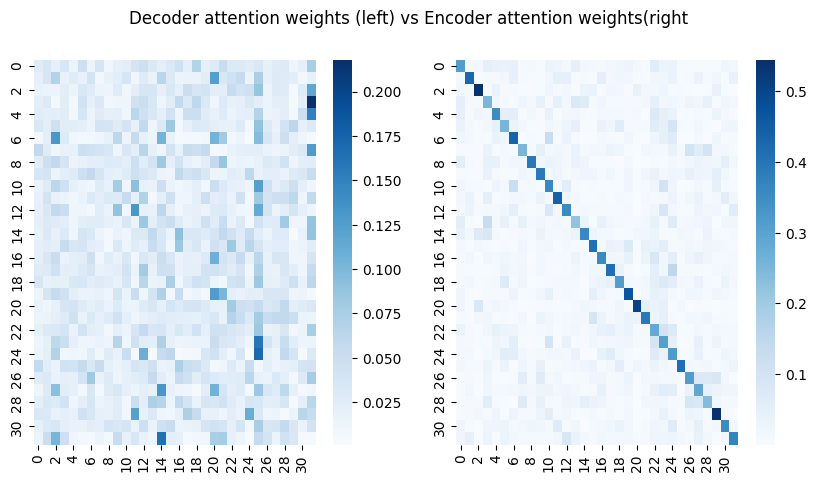

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Decoder attention weights (left) vs Encoder attention weights(right")
sns.heatmap(encoder_att_weights[0, 0, 0, ...], ax=ax[0], cmap="Blues")
sns.heatmap(decoder_att_weights[0, 0, 0, ...], ax=ax[1], cmap="Blues")
fig.show()

# **Training our model to invert sentences**

In [54]:
# Download data set
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

--2023-10-21 12:15:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-21 12:15:09 (18.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [55]:
BREAK_ORDS = (ord(" "), ord("\n"), ord("\t"), ord("."))


def ord_to_char(list_of_ords):
    """Format ascii np.array to char"""
    return "".join([chr(o) for o in list_of_ords])


class AsciiDatasetForInversionTask:
    """In-memory dataset of a single-file ASCII dataset for inversion task."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self.vocab_size = 128
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        if not corpus.isascii():
            raise ValueError("Loaded corpus is not ASCII.")

        if "\0" in corpus:
            # Reserve 0 codepoint for pad token.
            raise ValueError("Corpus must not contain null byte.")

        # Tokenize by taking ASCII codepoints.
        corpus = np.array([ord(c) for c in corpus if c != "\n"]).astype(np.int32)
        assert np.min(corpus) > 0
        assert np.max(corpus) < self.vocab_size  # Double-checking ASCII codepoints.

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = AsciiDatasetForInversionTask._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :], target=AsciiDatasetForInversionTask.invert_batch(batch)
        )

    def __iter__(self):
        return self

    @staticmethod
    def invert_batch(batch):
        inverted_batch = []
        for instance in batch:
            inverted_batch.append([])
            last_seen_space_index = len(instance)
            for i in range(len(instance) - 1, -1, -1):
                if instance[i] in BREAK_ORDS:
                    inverted_batch[-1].extend(instance[i + 1 : last_seen_space_index])
                    inverted_batch[-1].append(instance[i])
                    last_seen_space_index = i
            inverted_batch[-1].extend(instance[i:last_seen_space_index])
        return np.array(inverted_batch)

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result

In [56]:
batch_size = 2
seq_length = 32
train_dataset = AsciiDatasetForInversionTask("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size

batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("TEXT:", ord_to_char(obs))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("TEXT:", ord_to_char(target))
    print("ASCII:", target)


print(f"\n Total vocabulary size: {vocab_size}")

---------- Input -----------
TEXT: ak, speak.First Citizen:You are a
ASCII: [ 97 107  44  32 115 112 101  97 107  46  70 105 114 115 116  32  67 105
 116 105 122 101 110  58  89 111 117  32  97 114 101  32  97]
---------- Target ----------
TEXT: a are Citizen:You First.speak ak,
ASCII: [ 97  32  97 114 101  32  67 105 116 105 122 101 110  58  89 111 117  32
  70 105 114 115 116  46 115 112 101  97 107  32  97 107  44]
---------- Input -----------
TEXT: s't a verdict?All:No more talking
ASCII: [115  39 116  32  97  32 118 101 114 100 105  99 116  63  65 108 108  58
  78 111  32 109 111 114 101  32 116  97 108 107 105 110 103]
---------- Target ----------
TEXT: talking more verdict?All:No a s't
ASCII: [116  97 108 107 105 110 103  32 109 111 114 101  32 118 101 114 100 105
  99 116  63  65 108 108  58  78 111  32  97  32 115  39 116]

 Total vocabulary size: 128


In [57]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def sequence_loss_fn(logits, data):
    """Compute the loss on data wrt params."""
    targets = jax.nn.one_hot(data["target"], 128)
    assert logits.shape == targets.shape
    mask = jnp.greater(data["input"], 0)
    loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

In [58]:
# @title Run me to test your code
data = {"input": jnp.array([[0, 2, 0]]), "target": jnp.array([[0, 2, 0]])}
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, 128])
loss = sequence_loss_fn(X, data)
real_loss = jnp.array(5.2058086)
assert jnp.allclose(real_loss, loss), "Not returning the correct value"
print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


# **Viewing it as an generative task**
Training and inspecting models

In [59]:
def build_forward_fn(
    vocab_size, d_model, num_heads, num_layers, widening_factor, generative=False
):
    def forward_fn(data, training=True, return_weights=False, vocab_size=vocab_size):
        """Forward pass."""
        tokens = data["input"]
        tokens_target = data["target"]

        # if generative, we need new token to say start generating
        if generative:
            vocab_size = vocab_size + 1

        # Embed the input tokens and positions.
        embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
        token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
        token_embs = token_embedding_map(tokens)

        # Run the transformer over the inputs.
        transformer = Transformer(num_heads, num_layers, d_model, widening_factor)

        if generative:
            # inject "start" token into target codes
            start_token = jnp.ones(
                (data["target"].shape[0], 1), dtype=jnp.int32
            ) + jnp.array(vocab_size, dtype=jnp.int32)
            tokens_target = jnp.concatenate((start_token, tokens_target), axis=1)
            token_target_emb = token_embedding_map(tokens_target)

            max_mask_shape = max(tokens.shape[1], tokens_target.shape[1])
            decoding_mask = jnp.tril(jnp.ones((tokens.shape[0], max_mask_shape)))
            output_embeddings, weights1, weights2 = transformer(
                token_embs, token_target_emb, None, decoding_mask, return_weights=True
            )
            # Predict the token IDs

            if training:
              logits = hk.Linear(vocab_size - 1)(output_embeddings)[
                  :, :-1, ...
              ]  # we don't want predictions after sequence size
            else:
              logits = hk.Linear(vocab_size - 1)(output_embeddings)
        else:
            output_embeddings, weights1, weights2 = transformer(
                token_embs, token_embs, None, None, return_weights=True
            )
            # Predict the token IDs
            logits = hk.Linear(vocab_size)(output_embeddings)

        return logits if not return_weights else (logits, weights1, weights2)

    return forward_fn

Training the parallel classifier

In [60]:
d_model = 128
num_heads = 4
num_layers = 1
widening_factor = 4
LR = 1e-3

batch_size = 64
seq_length = 32
generative = False

# set up the data
train_dataset = AsciiDatasetForInversionTask("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

# initialise model
rng = jax.random.PRNGKey(42)
forward_fn = hk.transform(
    build_forward_fn(
        vocab_size, d_model, num_heads, num_layers, widening_factor, generative
    )
)
params = forward_fn.init(rng, batch)

# set up the optimiser
optimiser = optax.chain(optax.clip_by_global_norm(1), optax.adam(LR, b1=0.9, b2=0.99))
opt_state = optimiser.init(params)

In [61]:
# @title Haiku functions required for training - optional, but run this code block

# set up function calculating loss
def loss(params, batch):
    vocab_size = 128
    key = jax.random.PRNGKey(42)
    logits = forward_fn.apply(params, key, batch)
    batch_loss = sequence_loss_fn(logits, batch)
    return batch_loss


@jax.jit
def update(params, opt_state, batch):
    # get data neded for training
    grads = jax.grad(loss)(params, batch)
    updates, opt_state = optimiser.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


# calculate loss per batch
@jax.jit
def calculate_batch_loss(params, batch, vocab_size):
    key = jax.random.PRNGKey(42)
    logits = forward_fn.apply(params, key, batch)

    return sequence_loss_fn(logits, batch)

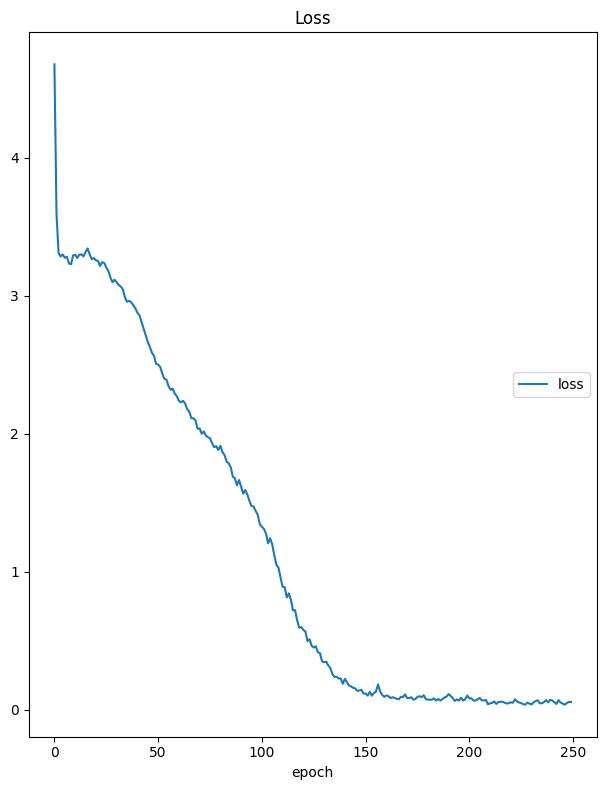

Loss
	loss             	 (min:    0.038, max:    4.677, cur:    0.058)


In [62]:
MAX_STEPS = 2000
LOG_EVERY = 8
losses = []


plotlosses = PlotLosses()
key = jax.random.PRNGKey(42)

# Training & evaluation loop.
for step in range(MAX_STEPS):
    data = next(train_dataset)
    params, opt_state = update(params, opt_state, data)
    losses.append(calculate_batch_loss(params, data, vocab_size))

    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []

In [63]:
def get_model_prediction(params, data, generator_inference=True):
  '''
  Get the model output
  '''
  key = jax.random.PRNGKey(42)
  logits, encoder_weights, decoder_weights = forward_fn.apply(
      params, key, data, not generator_inference, True
  )
  argmax_out = jnp.argmax(logits, axis=-1)
  text_out = [ord_to_char(out) for out in argmax_out]

  if generator_inference:
    return text_out, argmax_out, encoder_weights, decoder_weights
  else:
    return text_out, encoder_weights, decoder_weights

In [64]:
data = next(train_dataset)

predicted_string, encoder_weights, decoder_weights = get_model_prediction(
    params, data, False
)
target_string = [ord_to_char(t) for t in data["target"]]
input_string = [ord_to_char(t) for t in data["input"]]

for y_hat, y, input_ in zip(predicted_string[:2], target_string[:2], input_string[:2]):
    print("-" * 10, "Input", "-" * 11)
    print(input_)
    print("-" * 10, "Target", "-" * 10)
    print(y)
    print("-" * 10, "Prediction", "-" * 10)
    print(y_hat)
    print()
    print("*" * 50)

---------- Input -----------
 to any manUntil the elder sister
---------- Target ----------
sister elder the manUntil any to 
---------- Prediction ----------
sister elder the manUntil any to 

**************************************************
---------- Input -----------
nother way the sheets:Ay, and ami
---------- Target ----------
ami and sheets:Ay, the way nother
---------- Prediction ----------
ami and sheets:Ay, the way nother

**************************************************


In [65]:
def plot_weights(mean_weights, num_layers, num_heads, block="Encoder"):
    for layer in range(num_layers):
        fig, ax = plt.subplots(1, num_heads, figsize=(45, 5))
        plt.suptitle(f"Encoder Layer {layer} attention heads")
        for h in range(num_heads):
            ax[h].set_title(f"Head {h}")
            sns.heatmap(mean_weights[layer, h, ...], ax=ax[h], cmap="Blues")
        fig.show()

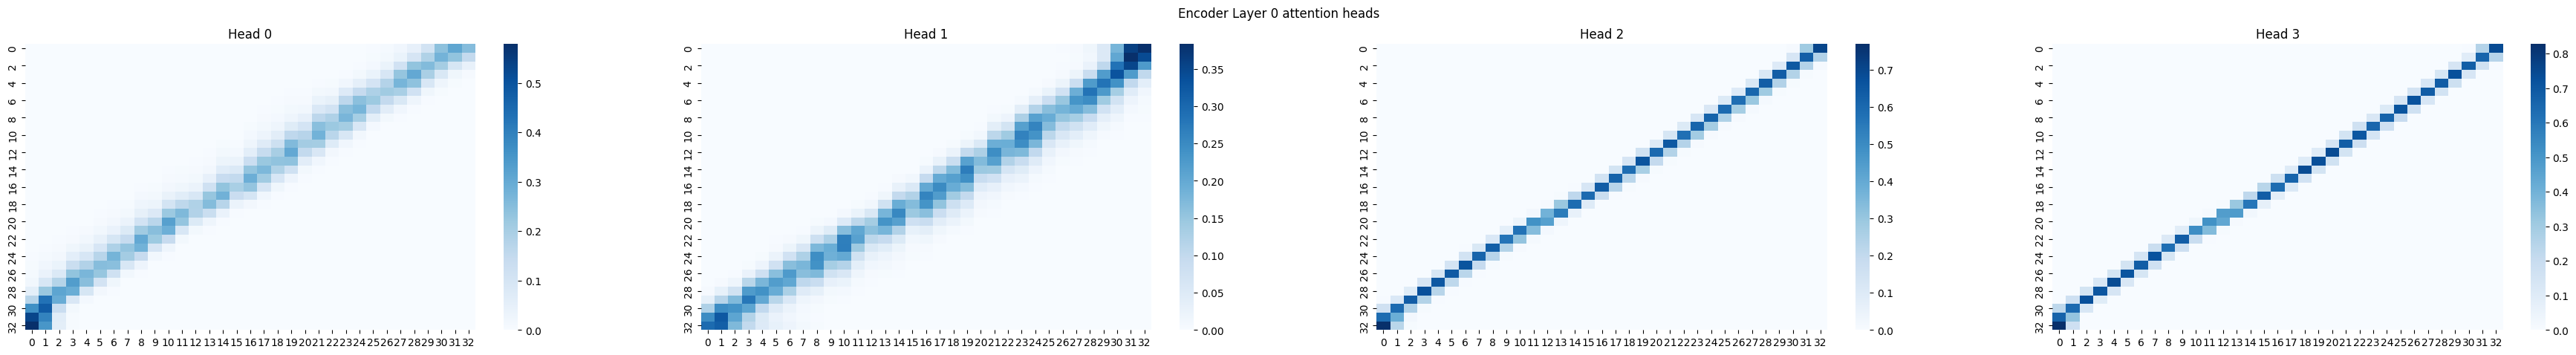

In [66]:
mean_encoder_weights = jnp.mean(encoder_weights, axis=0)
plot_weights(mean_encoder_weights, num_layers, num_heads, block="Encoder")

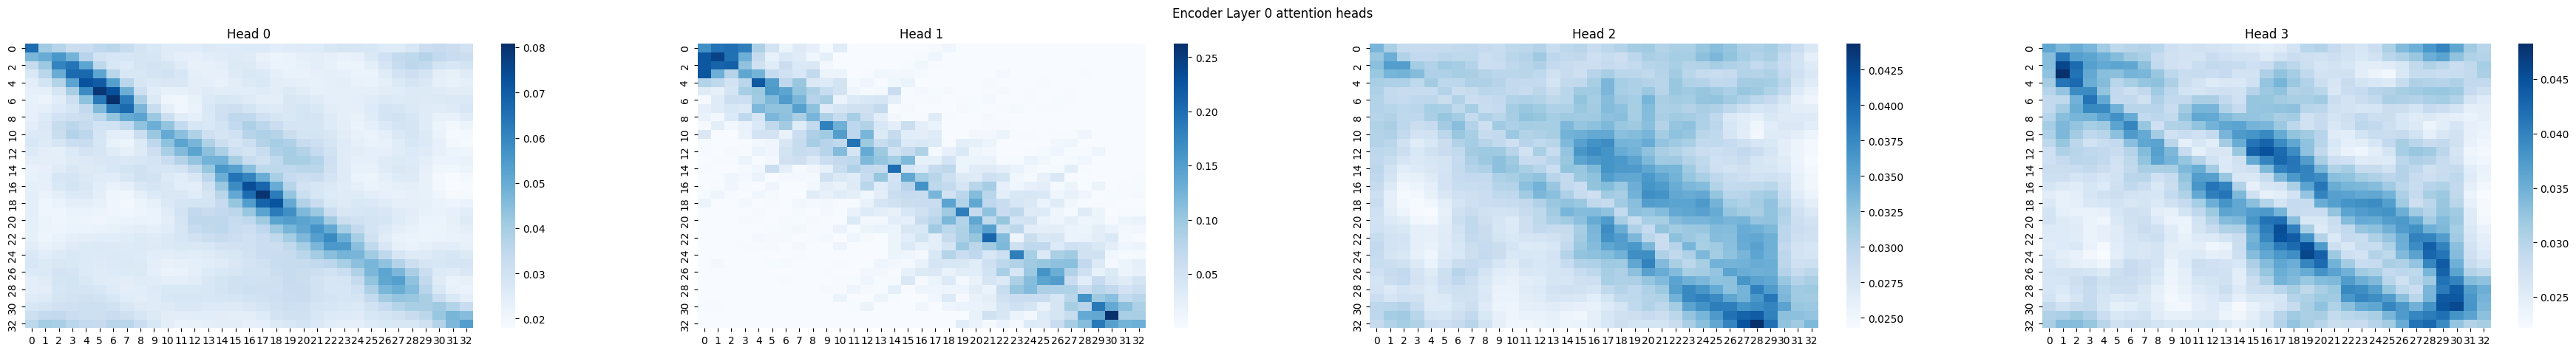

In [67]:
mean_decoder_weights = jnp.mean(decoder_weights, axis=0)
plot_weights(mean_decoder_weights, num_layers, num_heads, block="Decoder")

# **Training generator**

In [69]:
d_model = 128
num_heads = 2
num_layers = 3
widening_factor = 2
LR = 1e-3

batch_size = 64
seq_length = 32
generative = True

# set up the data
train_dataset = AsciiDatasetForInversionTask("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

# initialise model
rng = jax.random.PRNGKey(42)
forward_fn = hk.transform(
    build_forward_fn(
        vocab_size, d_model, num_heads, num_layers, widening_factor, generative
    )
)
params = forward_fn.init(rng, batch)

# set up the optimiser
optimiser = optax.chain(optax.clip_by_global_norm(1), optax.adam(LR, b1=0.9, b2=0.99))
opt_state = optimiser.init(params)

ValueError: ignored

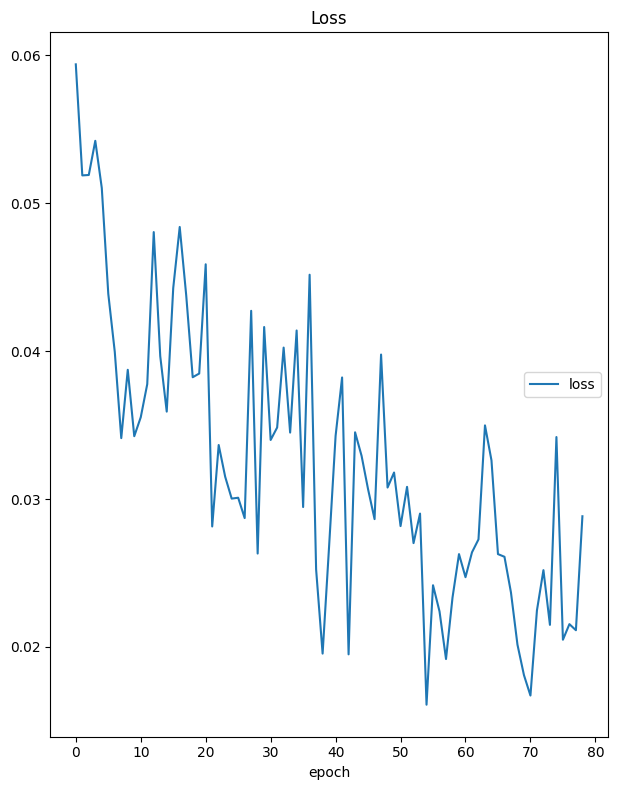

Loss
	loss             	 (min:    0.016, max:    0.059, cur:    0.029)


In [70]:
plotlosses = PlotLosses()

MAX_STEPS = 2500
LOG_EVERY = 32
losses = []

key = jax.random.PRNGKey(42)
# Training & evaluation loop.
for step in range(MAX_STEPS):
    data = next(train_dataset)
    params, opt_state = update(params, opt_state, data)
    losses.append(calculate_batch_loss(params, data, vocab_size))

    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []

In [71]:
data = next(train_dataset)

predicted_string, encoder_weights, decoder_weights = get_model_prediction(
    params, data, False
)
target_string = [ord_to_char(t) for t in data["target"]]
input_string = [ord_to_char(t) for t in data["input"]]

for y_hat, y, input_ in zip(predicted_string[:2], target_string[:2], input_string[:2]):
    print("-" * 10, "Input", "-" * 11)
    print(input_)
    print("-" * 10, "Target", "-" * 10)
    print(y)
    print("-" * 10, "Prediction", "-" * 10)
    print(y_hat)
    print()
    print("*" * 50)

ValueError: ignored

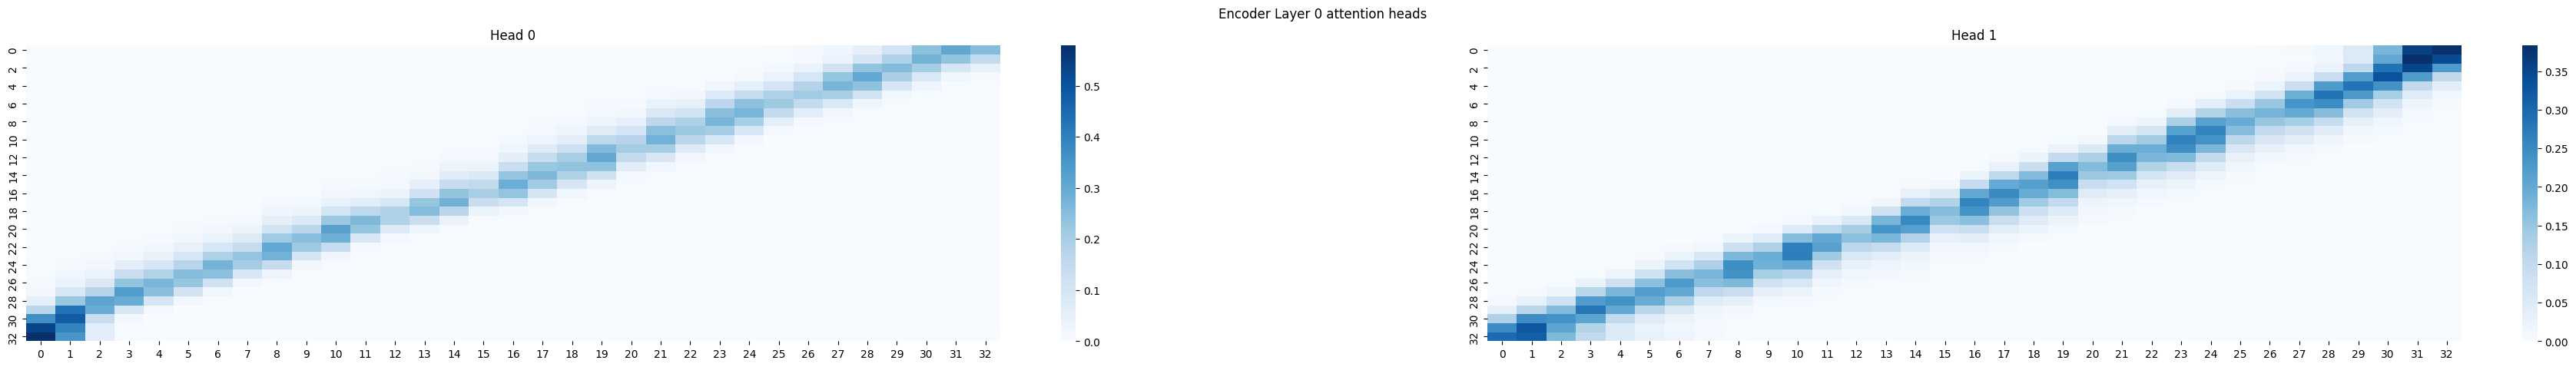

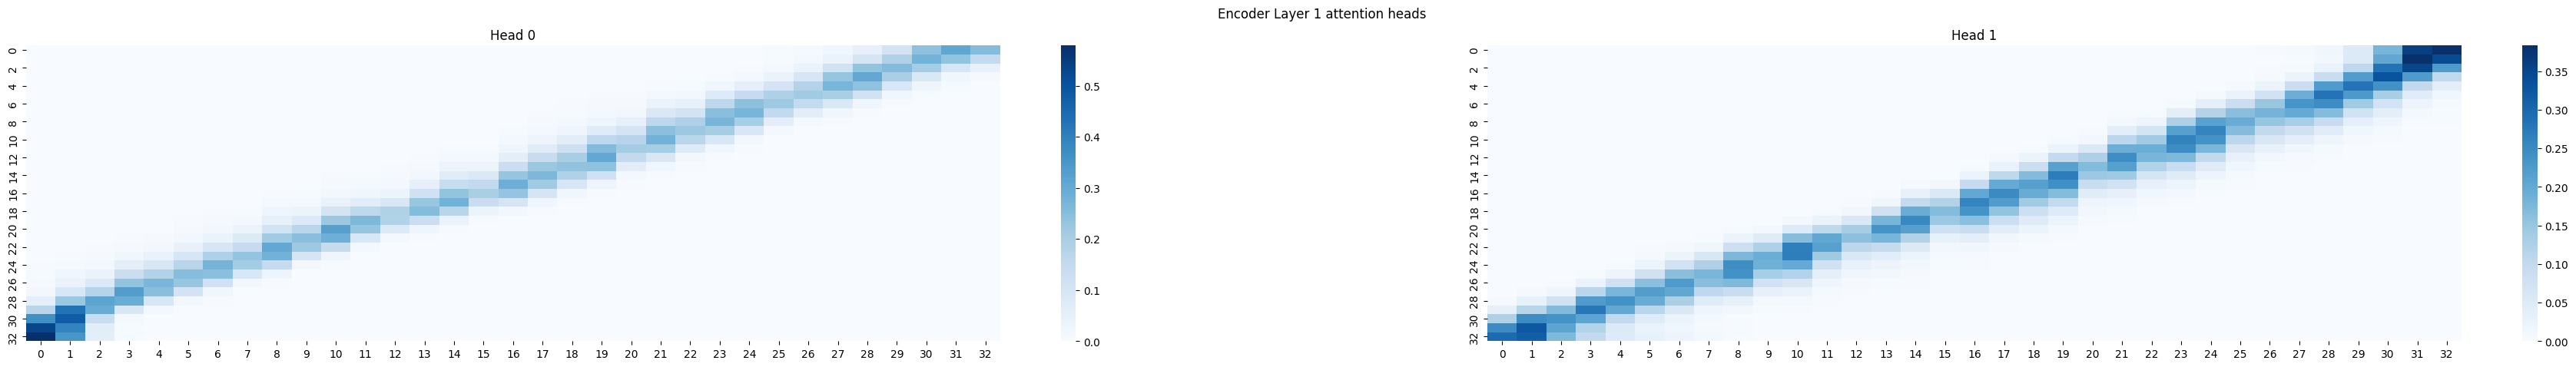

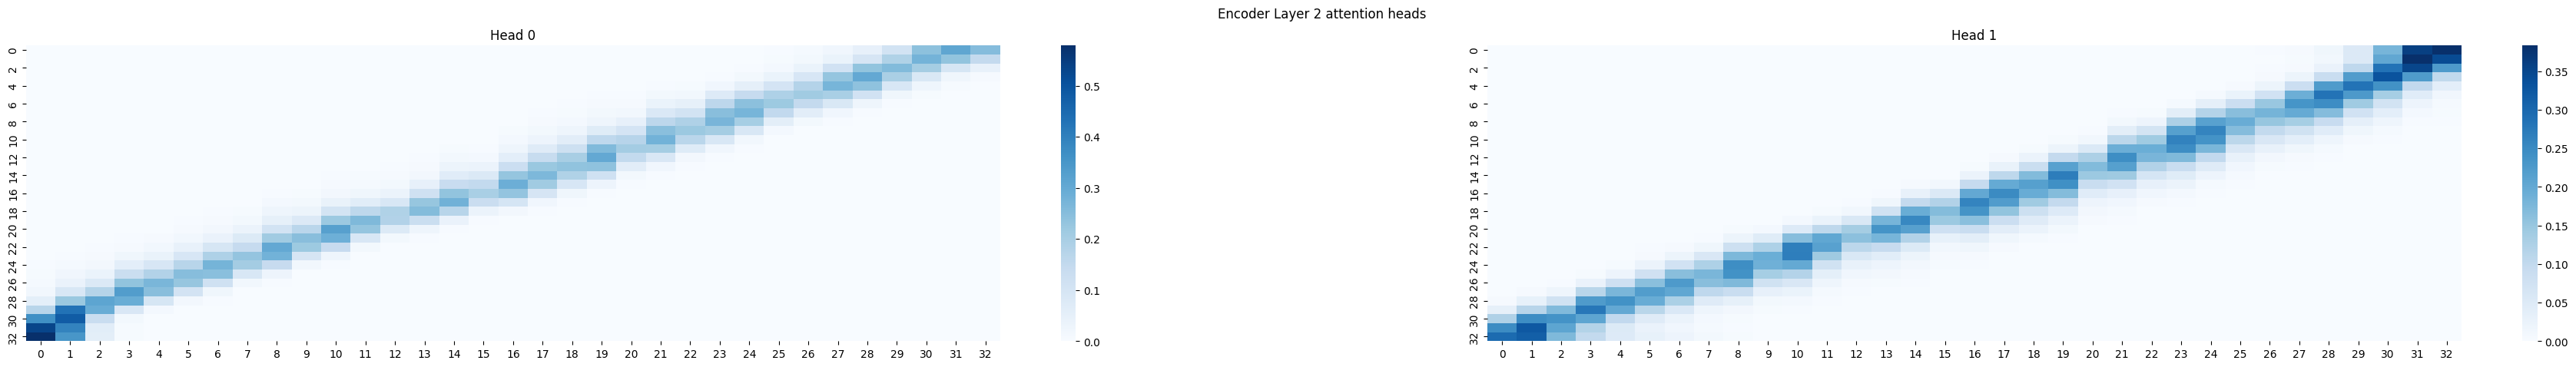

In [72]:
mean_encoder_weights = jnp.mean(encoder_weights, axis=0)
plot_weights(mean_encoder_weights, num_layers, num_heads, block="Encoder")

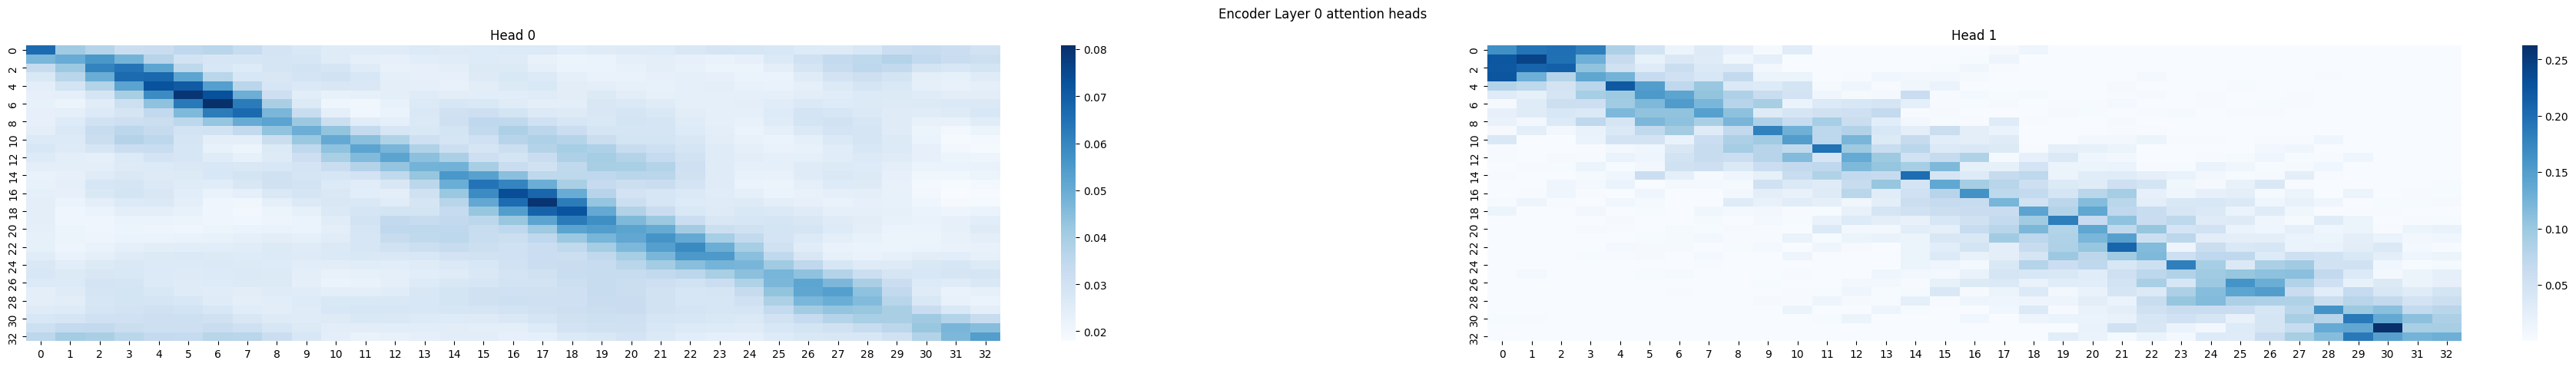

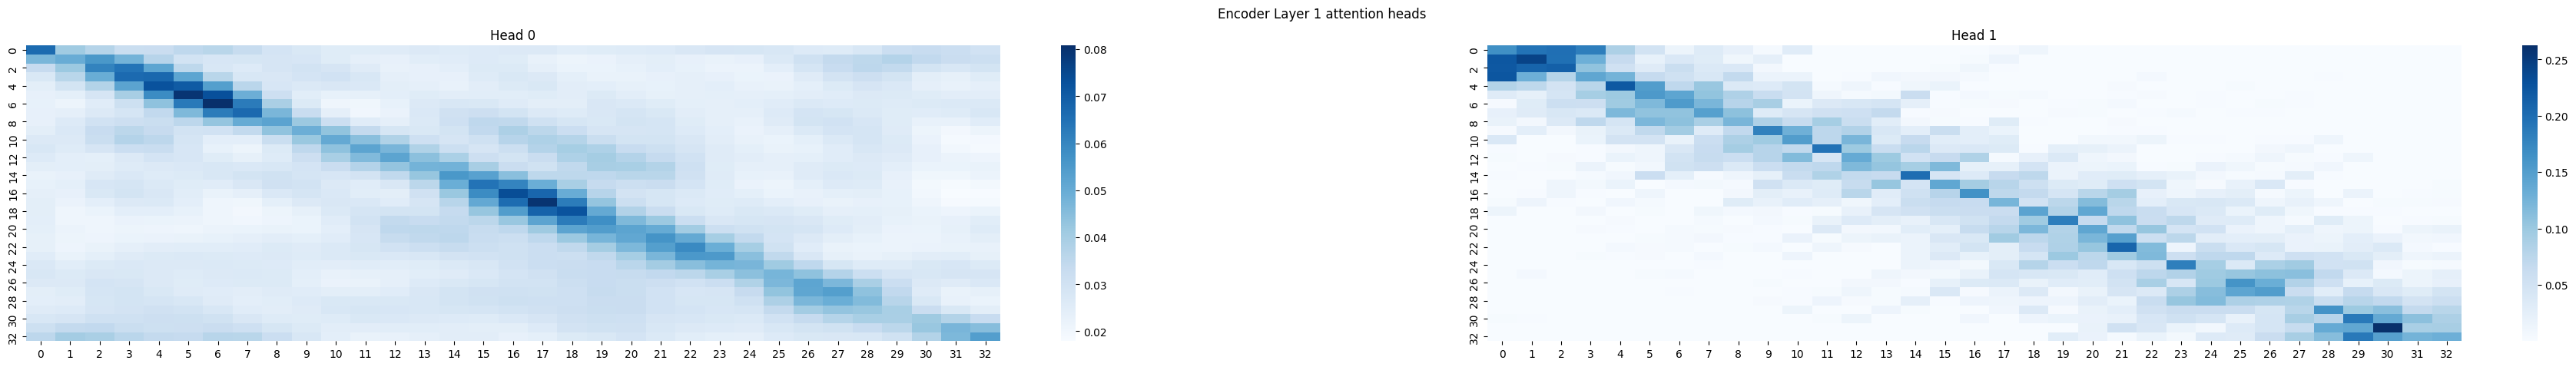

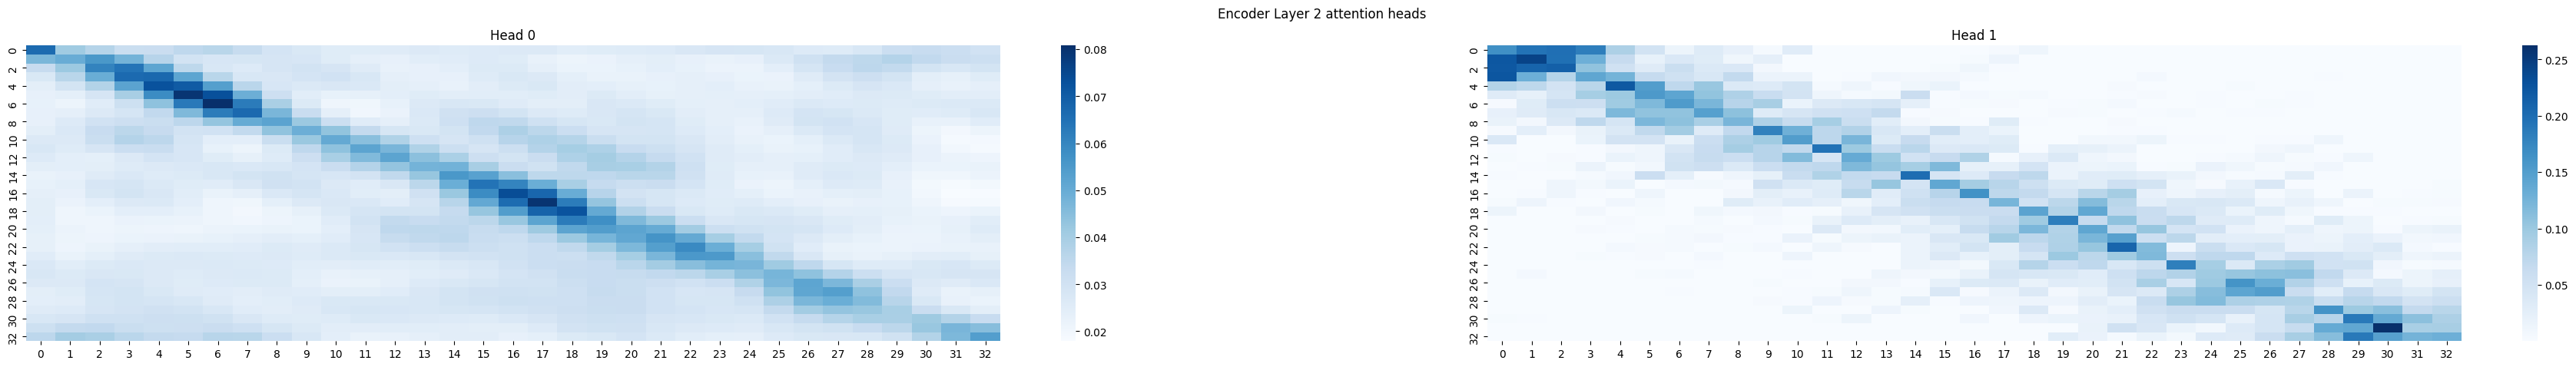

In [73]:
mean_decoder_weights = jnp.mean(decoder_weights, axis=0)
plot_weights(
    jnp.where(mean_decoder_weights == 1, 0.5, mean_decoder_weights),
    num_layers,
    num_heads,
    block="Decoder",
)